# CSU Bioinformatics Machine Learning -- Titanic

## Import Modules

Install these modules using [Anaconda's](https://www.anaconda.com/download/#linux) "conda install" or the graphical user interface:

 - scikit-learn
 - matplotlib
 - scipy
 - numpy
 - pandas
 - seaborn
 - jupyter

Make sure to create a new environment and activate the environment before running this notebook.  You can open a Jupyter notebook by opening a terminal or command prompt and typing "jupyter notebook".

In [9]:
import pandas as pd
import numpy as np
import sklearn as sk
from scipy import stats
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sbn
import warnings

## Load Data

This dataset is from Kaggle's Titanic: Machine Learning from Disaster competition.  You'll need to create a Kaggle account, join the competition (use the search feature), and download the data.  Put the data into a folder called "data" within the main folder directory.  This notebook should be run from the "notebook" folder for the file paths below to function correctly.

This dataset consists of three files:

 - train.csv: a comma-separated value file containing the training data.  This is data where we know whether or not the individual survived the Titanic sinking.
 - test.csv: a comma-separated value files containing the test data.  This is data where we don't know whether the individuals survived the Titanic sinking.
 - gender_submission.csv: this is an example submission file in the format required for Kaggle to "grade" our submission.  It contains the ID's of the test set and our prediction of their survival.
 
Below, we load the csv files using Pandas' read_csv function.  We then combine the training and testing sets by first making sure that their columns are named and ordered in the same manner; we need to drop the "Survived" column from the training data.  Pandas' drop function takes two arguments: a name (or number) and the axis number from which to drop the data (in this case, columns are axis number 1, since Python is a 0-indexed langauge).  We then visualize the first ten rows with the Pandas' head function.

The "features" are the columns, while the "observations" are the rows.  We will use the features to predict the outcome.  Since we are predicting either "Survived" or "Did not survive," we call this a binary classification problem.  In this data, we have the following features by default:

 - **PassengerId:** an identifier used by Kaggle for scoring; this isn't important to us except to format output for submission to Kaggle.
 - **Pclass:** the passenger class, one of 1st, 2nd, and 3rd class.
 - **Name:** the passenger name, which could contain additional information (like titles or marriage status).
 - **Sex:** the passenger's sex, one of male or female.
 - **Age:** the passenger's age in years.
 - **SibSp:** the number of siblings and spouses related to this passenger aboard the Titanic.
 - **Parch:** the number of parents and children related to this passenger aboard the Titanic.
 - **Ticket:** the ticket number (it is unclear what the letters are for, but they could be useful).
 - **Fare:** the ticket cost for the passenger.
 - **Cabin:** the cabin number for this passenger (letters and numbers, sometimes more than one).
 - **Embarked:** the port of embarkation, one of C (Cherbourg), Q (Queenstown), or S (Southampton).

In [3]:
train = pd.read_csv('../data/train.csv')  # load the training data
test = pd.read_csv('../data/test.csv')  # load the testing data
combined = pd.concat([train.drop('Survived', 1), test])  # remove the "Survived" column to combine them

combined.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**Data Exploration**

Now that we have glanced at the features, we should explore basic summary statistics about them to determine their normality and range.  The Age numeric feature appears relatively normal when comparing the median to the mean, however the Fare numeric feature is right-skewed.  We will likely have to log-transform the Fare for it to be closer to normal.  We strive for normality, since many machine learning algorithms assume an underlying normal distribution of data.  We will talk more about normalization and transformation of data at a later date.

Remember, the overall goal with data exploration is to get a sense of the datatypes, their distributions, and their importance to the outcome of interest (in this case, survival).

**Missing Values**

Missing values are common in data.  We need to determine which features have missing values to come up with a strategy to impute new values.  The training set primarily has missing values in the Age and Cabin features, however the Embarked feature also has two missing values.  The test set also has missing values for primarily Age and Cabin, but it also contains one missing value for Fare.  

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
print('The training data features contain the following missing values:')
print(train.isnull().sum())

print('\nThe test data features contain the following missing values:')
print(test.isnull().sum())

The training data features contain the following missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The test data features contain the following missing values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


**Plotting Data**

Visualizing data is critical to understanding the distribution and importance of the features to the outcome of interest.  Below, we first look at the overall distribution of the survival classes.  This is a fairly well-balanced classification problem, since the categories are relatively even.  If this were an unbalanced classification problem, it would affect our strategy of how to model the data, since one of the categories would have not as much information for training of the model.  Next, we use Seaborn and MatPlotLib to display the data color-coded by survival status or category.

In [8]:
surv = train[train['Survived'] == 1]  # which individuals survived?
died = train[train['Survived'] == 0]  # which individuals died?

print('Survived: {:d} ({:.1f} percent), Died: {:d} ({:.1f} percent), Total: {:d}'.format(
    len(surv), 
    100.0 * len(surv) / len(train),
    len(died),
    100.0 * len(died) / len(train),
    len(train)
))

Survived: 342 (38.4 percent), Died: 549 (61.6 percent), Total: 891


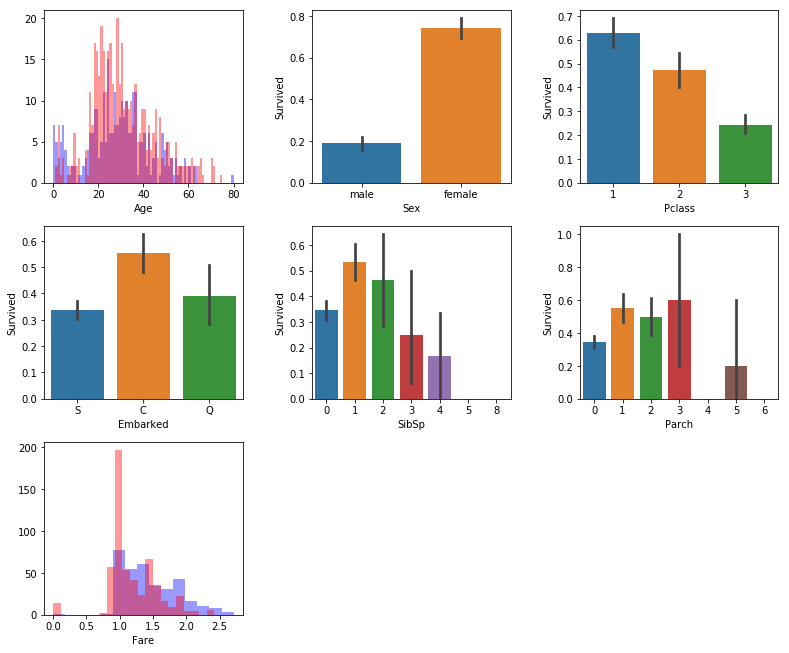

In [12]:
warnings.filterwarnings(action='ignore')  # suppress unnecessary warnings

plt.figure(figsize=[12,10])  # set up the parent plot space
plt.subplot(331)  # create the first subplot space
sbn.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='blue')  # Histogram for Age
sbn.distplot(died['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='red', axlabel='Age')

plt.subplot(332)  # create the second subplot space
sbn.barplot('Sex', 'Survived', data=train)  # Sex by survival category

plt.subplot(333) # create the third subplot space
sbn.barplot('Pclass', 'Survived', data=train)  # Pclass by survival category

plt.subplot(334) # create the third subplot space
sbn.barplot('Embarked', 'Survived', data=train)  # Embarked by survival category

plt.subplot(335) # create the third subplot space
sbn.barplot('SibSp', 'Survived', data=train)  # SibSp by survival category

plt.subplot(336) # create the third subplot space
sbn.barplot('Parch', 'Survived', data=train)  # Parch by survival category

plt.subplot(337) # create the third subplot space
# The np.log10(x + 1) is a log-transform using Numpy. We need to increment by 1 to avoid invalid values.
sbn.distplot(np.log10(surv['Fare'].dropna().values + 1), kde=False, color='blue')
sbn.distplot(np.log10(died['Fare'].dropna().values + 1), kde=False, color='red', axlabel='Fare')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)  # margins


**Observations about the Features**

It is clear that most of the numeric and categorical features tell us something about survival.  Keep in mind that these are simple observations and do not take into account confounding.:

 - Age: Very young and those around the age of 40-50 appear to have better survival odds.  The older group is likely confounded by something like Pclass (these may be wealthy individuals, for example).
 - Sex: Females have a much higher rate of survival.
 - Pclass: There is a fairly linear trend in survival depending on class; first class passengers were much more likely to survive than third class.
 - SibSp and Parch: Best survival odds occurred when a passenger had 1-2 other relatives on board.  Those with no relatives or with more than 2 relatives had lower survival rates.
 - Embarked: While it appears that those who embarked from "C" had a higher survival rate, this is likely due to confounding.  We will see once we start using regression-based modeling to determine feature importance.
 - Fare: Those who paid more money were more likely to survive.